# Agriculture Parcels Vs Non-Agriculture Parcels

In [2]:
#Step 1: Load the original dataset having Landuse_Ma columon. This dataset also have crop information. 

import geopandas as gpd
import pandas as pd
import numpy as np
import leafmap
import geemap
import ee

In [241]:
cropfile = 'D:\Trainings\gee\pabb_crop_V3.geojson'
gdf = gpd.read_file(cropfile)
gdf['Landuse_Ma'].groupby(gdf['Landuse_Ma']).count().sort_values(ascending=False)

Landuse_Ma
Agriculture     5759
Stream           302
Other            229
Road/Streets     172
Graveyard         29
Built up          24
Name: Landuse_Ma, dtype: int64

In [94]:

selected_parcels = gdf[gdf['Landuse_Ma'] == 'Agriculture']
print(f'Total Agriculture Parcels are :{len(selected_parcels)}') 
# These are the parcels with Landuse_Ma as Agriculture and will be used for further analysis.

Total Agriculture Parcels are :5759


## Data Cleansing
1. Calculating NDVI and NDBI of the selected agriculture parcels : 5759.

In [95]:
# Lets Convert the gdf of the original file to ee features utilizing earth engine power
ee.Authenticate()

ee.Initialize()
boundary = geemap.gdf_to_ee(gdf) # this is for cliping the images
selectedparcels_fc = geemap.gdf_to_ee(selected_parcels) # this is for getting the agriculture parcels features Collection 


In [96]:
# Define a function to get imagery an apply filter
def get_collection (start_date,end_date):
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    filtered_collection = collection.filterDate(start_date, end_date).filterBounds(boundary.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    return filtered_collection

In [97]:
# defing ndvi , NDBI , BUI and UI indices

def get_ndvi(filtered_collection):
    # Calculate the annual NDVI from the filtered collection (filtered_collection)
    ndvi_collection = filtered_collection.map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    # Calculate the mean NDVI for the year
    mean_ndvi = ndvi_collection.mean()
    return mean_ndvi
    
def get_ndbi(filtered_collection):
    # Calculate Normalized Difference Built-up Index (NDBI) (SWIR−NIR)/(SWIR+NIR) from the filtered collection filtered_collection
    # NDBI = (B11 - B8) / (B11 + B8)
    # Built‑up areas (positive values) vs. vegetation/water (negative)
    ndbi_collection = filtered_collection.map(lambda img: img.normalizedDifference(['B11', 'B8']).rename('NDBI'))
    # Calculate the mean NDBI for the year
    mean_ndbi = ndbi_collection.mean()
    return mean_ndbi
def get_ndwi(filtered_collection):
    # Calculate Normalized Difference Water Index (NDWI) (Green-NIR)/(Green+NIR) from the filtered collection filtered_collection
    # NDWI = (B3 - B8) / (B3 + B8)
    # Water (positive values) vs. built-up/vegetation (negative)
    ndwi_collection = filtered_collection.map(lambda img: img.normalizedDifference(['B3', 'B8']).rename('NDWI'))
    # Calculate the mean NDWI for the year
    mean_ndwi = ndwi_collection.mean()
    return mean_ndwi

def get_bui(filtered_collection):
    # Calculate the annual Built-Up Index (BUI) for an ee.ImageCollection `filtered_collection`.
    # BUI: (B11 + B4 - B8 - B2) / (B11 + B4 + B8 + B2)
    # Enhances urban density separation from other land‑covers
    bui_collection = filtered_collection.map(lambda img: (img.select('B11').add(img.select('B4')).subtract(img.select('B8'))
           .subtract(img.select('B2'))
           .divide(
               img.select('B11').add(img.select('B4'))
                  .add(img.select('B8'))
                  .add(img.select('B2'))
           )
           .rename('BUI')      
                    ))
    mean_bui = bui_collection.mean()
    return mean_bui
    
def get_ui(filtered_collection):
    # Calculate Urban Index (UI) (NDBI−NDVI)/(NDBI+NDVI) for the collection
    # Separates built‑up from vegetation more robustly
    mean_ndvi = get_ndvi(filtered_collection)
    mean_ndbi = get_ndbi(filtered_collection)
    mean_ui = mean_ndbi.subtract(mean_ndvi).divide(mean_ndbi.add(mean_ndvi)).rename('UI')
    return mean_ui



In [98]:
def get_composite(filtered_collection,ndvi_img, ndbi_img, bui_img, ui_img,ndwi_img):
    """
    Stack the four annual‐mean index images into one composite,
    then clip it to the boundary.
    """
    selected_bands = ['B2', 'B3', 'B4', 'B8', 'B11']
    filtered_collection = filtered_collection.select(selected_bands)
    
    #Now add the indices to each image in the filtered collection
    filtered_collection = filtered_collection.map(lambda img: img.addBands(ndvi_img).addBands(ndbi_img).addBands(bui_img).addBands(ui_img).addBands(ndwi_img))  
    
    # Reduce the collection to a mean single image
    composite_img = filtered_collection.mean()
    
    # Rename the bands in the correct order
    composite_img = composite_img.rename(['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI','NDWI'])
    
    # 3. Clip to your boundary
    composite_img = composite_img.clip(boundary.geometry())
    
    return composite_img


In [99]:
filtered_collection = get_collection('2022-01-01', '2024-12-31')
ndvi_img = get_ndvi(filtered_collection)
ndbi_img = get_ndbi(filtered_collection)
bui_img = get_bui(filtered_collection)
ui_img = get_ui(filtered_collection)
ndwi_img = get_ndwi(filtered_collection)

composite_img = get_composite(filtered_collection, ndvi_img, ndbi_img, bui_img, ui_img, ndwi_img)

In [100]:
def sum_count(filtered_collection, parcels_fc,agrithresh=0.3, builtdiff =0.0):
        
    flagged = filtered_collection.map(lambda img: mask_flags(img, agrithresh, builtdiff))
    
    count_image = flagged.select(['agri_count','built_count']).sum()

    stats_fc = count_image.reduceRegions(
        collection=parcels_fc,
        reducer=ee.Reducer.sum(),
        scale=10,
        crs=count_image.projection()
    )
    return stats_fc


def mask_flags(img,agrithresh, builtdiff):
    
    #compute the NDVI and NDBI for each image in the collection
    ndvi = img.normalizedDifference(['B8', 'B4'])
    ndbi = img.normalizedDifference(['B11', 'B8'])
    # create a boolean mask and cast to int (1 if true and 0 if false)
    agri_flag = ndvi.gt(agrithresh).rename('agri_count').toInt()
    built_flag = ndbi.gt(builtdiff).rename('built_count').toInt()
    return img.addBands([agri_flag,built_flag])


In [101]:
# The composite Image which is mean of all the indices and bands is now used to 
# calculate the mean of each index and bands in the composite image.

def mean_indices(composite_img, parcels_fc):
    #Select the bands of interest
    b2 = composite_img.select('B2')
    b3 = composite_img.select('B3')
    b4 = composite_img.select('B4')
    b8 = composite_img.select('B8')
    b11 = composite_img.select('B11')


    # Select the indices
    ndvi = composite_img.select('NDVI')
    ndbi = composite_img.select('NDBI')
    ui = composite_img.select('UI')
    bui = composite_img.select('BUI')
    ndwi = composite_img.select('NDWI')

    index_img = ee.Image.cat([b2,b3,b4,b8,b11,ndvi,ndbi,bui,ui,ndwi])
    mean_img = index_img.reduceRegions(
        collection=parcels_fc,
        reducer=ee.Reducer.mean(),
        scale=10,
        crs=composite_img.projection()
    )
    return mean_img


In [102]:
pxlsum = sum_count(filtered_collection,selectedparcels_fc,agrithresh=0.3, builtdiff =0.0)
pxlmean = mean_indices(composite_img, selectedparcels_fc)
# Convert the ee.FeatureCollection to a pandas DataFrame
pxlsum_gdf= geemap.ee_to_gdf(pxlsum)
pxlmean_gdf= geemap.ee_to_gdf(pxlmean)  


In [104]:
pxlmean_gdf.head()

,geometry,Area_Acre,B11,B2,B3,B4,B8,BUI,Crop_Type,FFID,Landuse_Ma,Mouza_Name,NDBI,NDVI,NDWI,Parcel_ID,UI
0,"POLYGON ((71.74996 34.03193, 71.75027 34.03195...",0.101785,2147.930654,1080.794583,1314.424346,1412.001354,2250.015724,0.037398,None,1,Agriculture,Khushmaqam,-0.016614,0.226656,-0.261929,668,-1.202087
1,"POLYGON ((71.74868 34.03205, 71.74869 34.03195...",0.315557,2148.237869,905.980655,1133.265953,1248.493593,2115.168267,0.060771,None,3,Agriculture,Khushmaqam,0.013744,0.254974,-0.298905,632,-0.876391
2,"POLYGON ((71.75021 34.03218, 71.75022 34.0321,...",0.187644,2198.647527,989.403836,1234.108843,1331.561342,2231.942662,0.047527,None,4,Agriculture,Khushmaqam,-0.003842,0.248897,-0.284861,669,-1.022695
3,"POLYGON ((71.75401 34.03224, 71.75403 34.03219...",0.161568,2193.297278,806.999988,1099.118312,1177.751882,2761.666157,-0.038227,None,5,Agriculture,Khushmaqam,-0.109844,0.410130,-0.431634,693,-1.738528
4,"POLYGON ((71.74971 34.03192, 71.74996 34.03193...",0.229336,2126.134001,1160.127481,1376.297936,1480.144814,2196.267099,0.039058,None,6,Agriculture,Khushmaqam,-0.011919,0.197473,-0.233127,667,-1.196795


In [191]:
# since both dataframes have duplicate columns therefore to avoid duplicaiton 
# we will select the columns we need for merging
mean_cols = ['geometry','B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI','NDWI']
plxmean_small = pxlmean_gdf[mean_cols]

#Now we will merge the two dataframes
stats_gdf = pxlsum_gdf.merge(plxmean_small, on='geometry', how='left')

print(stats_gdf.columns.tolist())

['geometry', 'Area_Acre', 'Crop_Type', 'FFID', 'Landuse_Ma', 'Mouza_Name', 'Parcel_ID', 'agri_count', 'built_count', 'B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI', 'NDWI']


In [192]:
# Now stats_gdf has columns 'built_count' and 'agri_count' per parcel
# Lets compute the percentage of built and agri land
stats_gdf['pct_built'] = stats_gdf['built_count'] / (stats_gdf['built_count'] + stats_gdf['agri_count'])
stats_gdf['pct_agri']  = stats_gdf['agri_count']  / (stats_gdf['built_count'] + stats_gdf['agri_count'])


In [194]:
def high_confidence_label(row,
                          ndvi_ag=0.35,     # only very green
                          ui_ag_max=0.05,   # near zero build
                          pa_ag=0.80,       # ≥80% ag cover
                          ui_non=0.25,      # definitely built
                          pb_non=0.50       # ≥50% built cover
                         ):
    ndvi = row['NDVI']
    ui   = row['UI']
    pa   = row['pct_agri']
    pb   = row['pct_built']
    
    # HIGH-CONFIDENCE AGRICULTURE
    if ndvi >= ndvi_ag and ui <= ui_ag_max and pa >= pa_ag:
        return 'Agriculture'
    
    # HIGH-CONFIDENCE NON-AGRICULTURE
    if ui >= ui_non or pb >= pb_non:
        return 'Non-Agriculture'
    
    # UNCERTAIN
    return None

stats_gdf['hc_label'] = stats_gdf.apply(high_confidence_label, axis=1)
print(stats_gdf['hc_label'].value_counts())

hc_label
Agriculture        1985
Non-Agriculture    1425
Name: count, dtype: int64


In [195]:
agriculture = stats_gdf[stats_gdf['hc_label'] == 'Agriculture']
nonagriculture = stats_gdf[stats_gdf['hc_label'] == 'Non-Agriculture']


In [110]:
#This map just give you the visualization of High confident labels

m = leafmap.Map(center=(37.5, 70), )
m.add_basemap('Google Satellite')

# 1. Create a minimal GeoDataFrame with only geometry + landuse_class
popup_gdf = stats_gdf[['geometry', 'hc_label']].copy()


legend_dict = {
    'Agriculture':           '#00AA00',  # dark green
    'Non-Agriculture':       '#00008B',  # darkblue
    }


m.add_gdf(
    popup_gdf,
    layer_name='Landuse Class',
    style={                      # pick any style you like
        'color':   'black',
        'fillColor':'transparent',
        'fillOpacity': 0.1,
        'weight':  1
    },
    zoom_to_layer=True,
    info_mode='on_click'        # show popup when you click
)

# Agriculture
m.add_gdf(
    agriculture,
    layer_name='Agriculture',
    style={
        'color': 'green',      # border
        'fillColor': 'green',  # interior
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
     
)
# Non-Agriculture
m.add_gdf(
    nonagriculture,
    layer_name='Non-Agriculture',
    style={
        'color': 'blue',
        'fillColor': 'blue',
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
    
)
# Add legend
m.add_legend(
    legend_title='Landuse Classification',
    legend_dict=legend_dict,
    position='bottomleft'
)

m.add_layer_manager()

m

Map(center=[37.5, 70], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# Training Random Forest

In [ ]:
# Step 1: Training our model to predct the landuse classes which was not possible manually through high confidence labels.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#prepare training data
train = stats_gdf.dropna(subset = ['hc_label'])

X = train[['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI','NDWI']].values
y = (train['hc_label'] == 'Agriculture').astype(int)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

#Train the model
rf= RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train ,y_train) # Training the model
y_pred = rf.predict(X_test) # Testing the model

In [197]:
#Priting classification report and Confusion matrix
# Evaluate the Performance of the model

# 5) Print the classification report
print("Classification Report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=['Non-Agriculture','Agriculture']
))

# 6) Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Classification Report:

                 precision    recall  f1-score   support

Non-Agriculture       0.99      0.98      0.99       285
    Agriculture       0.99      0.99      0.99       397

       accuracy                           0.99       682
      macro avg       0.99      0.99      0.99       682
   weighted avg       0.99      0.99      0.99       682

Confusion Matrix:
 [[279   6]
 [  2 395]]


In [198]:
# Predicting the unlabeled Parcels

unlabeled = stats_gdf[stats_gdf['hc_label'].isna()]

X_unlbl = unlabeled[['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI','NDWI']].values

probs = rf.predict_proba(X_unlbl)[:,1]
unlabeled['rf_prob_ag'] = probs

#Hard-Classify at 0.5 (threshold)

unlabeled['rf_label'] = np.where(probs>0.5, 'Agriculture', 'Non-Agriculture')

In [199]:
# To leave the very low confidence RF Preictions unassigned.
threshold_low , threshold_high= 0.3,0.7

unlabeled['predicted_label'] = np.where(probs > threshold_high, 'Agriculture',
                                        np.where(probs < threshold_low, 'Non-Agriculture', None))


In [200]:
pred_agri = unlabeled[unlabeled['predicted_label']== 'Agriculture']
pred_nonagri = unlabeled[unlabeled['predicted_label']== 'Non-Agriculture']
pred_unassigned = unlabeled[unlabeled['predicted_label']== None]

In [201]:
# Lets Create one Final dataset with target_labels for crop Random Forest
stats_gdf = stats_gdf.merge(unlabeled[['FFID','predicted_label']], on='FFID',how= 'left')
stats_gdf['target_label'] = stats_gdf['hc_label'].fillna(stats_gdf['predicted_label'])

stats_gdf.head()

,geometry,Area_Acre,Crop_Type,FFID,Landuse_Ma,Mouza_Name,Parcel_ID,agri_count,built_count,B2,...,NDVI,NDBI,BUI,UI,NDWI,pct_built,pct_agri,hc_label,predicted_label,target_label
0,"POLYGON ((71.74996 34.03193, 71.75027 34.03195...",0.101785,None,1,Agriculture,Khushmaqam,668,90.725490,181.058824,1080.794583,...,0.226656,-0.016614,0.037398,-1.202087,-0.261929,0.666186,0.333814,Non-Agriculture,NaN,Non-Agriculture
1,"POLYGON ((71.74868 34.03205, 71.74869 34.03195...",0.315557,None,3,Agriculture,Khushmaqam,632,445.384314,928.509804,905.980655,...,0.254974,0.013744,0.060771,-0.876391,-0.298905,0.675823,0.324177,Non-Agriculture,NaN,Non-Agriculture
2,"POLYGON ((71.75021 34.03218, 71.75022 34.0321,...",0.187644,None,4,Agriculture,Khushmaqam,669,241.717647,430.784314,989.403836,...,0.248897,-0.003842,0.047527,-1.022695,-0.284861,0.640570,0.359430,Non-Agriculture,NaN,Non-Agriculture
3,"POLYGON ((71.75401 34.03224, 71.75403 34.03219...",0.161568,None,5,Agriculture,Khushmaqam,693,955.690196,434.231373,806.999988,...,0.410130,-0.109844,-0.038227,-1.738528,-0.431634,0.312414,0.687586,None,Agriculture,Agriculture
4,"POLYGON ((71.74971 34.03192, 71.74996 34.03193...",0.229336,None,6,Agriculture,Khushmaqam,667,170.831373,437.709804,1160.127481,...,0.197473,-0.011919,0.039058,-1.196795,-0.233127,0.719277,0.280723,Non-Agriculture,NaN,Non-Agriculture


In [202]:
# Lets save the model for future use
import joblib
joblib.dump(rf, 'agri_nonagri-V1.pkl')   

['agri_nonagri-V1.pkl']

In [203]:
stats_gdf.to_file('Pabbi_AgriVsNonAgri-V-1.geojson')

In [118]:
m = leafmap.Map(center=(37.5, 70), zoom=6)
m.add_basemap('Google Satellite')

# 1. Create a minimal GeoDataFrame with only geometry + Target
popup_gdf = stats_gdf[['geometry', 'target_label']].copy()

# 2. Add your styling layers *without* popups
layers_lsit = [ 
    (agriculture,    'Agriculture',             legend_dict['Agriculture']),
    (nonagriculture,   'NonAgricultrue',        legend_dict['Non-Agriculture']),
        ]

for gdf, name, color in layers_lsit:
    # 2.1 Add the layer to the map   
    m.add_gdf(
        gdf,
        layer_name=name,
        style={
            'color':    color,
            'fillColor':color,
            'fillOpacity':0.3,
            'weight':   1
        },
        zoom_to_layer=True,
        info_mode='off'   # make sure no popups for these layers
    )

# 3. Add your minimal layer *last*, with popups ON only for landuse_class
m.add_gdf(
    popup_gdf,
    layer_name='Landuse Class',
    style={
        'color':      'black',
        'fillColor': 'transparent',
        'fillOpacity':0.1,
        'weight':     1
    },
    info_mode='on_click'  # only this layer shows a popup
)

# Adding the predicted Agriculture and Non-Agriculture parcels
m.add_gdf(
    pred_agri,
    layer_name='Predicted Agriculture',
    style={
        'color': 'lightgreen',
        'fillColor': 'lightgreen',
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
)
m.add_gdf(
    pred_nonagri,
    layer_name='Predicted Non-Agriculture',
    style={
        'color': 'lightblue',
        'fillColor': 'lightblue',
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
)


# 4. Legend & Layer Manager
m.add_legend(
    legend_title='Agriculture vs Non-Agriculture',
    legend_dict=legend_dict,
    position='bottomleft'
)

m.add_layer_manager()

m


Map(center=[37.5, 70], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [204]:
len(stats_gdf)

5759

In [205]:
rf_gdf = stats_gdf.copy()
rf_gdf.columns

Index(['geometry', 'Area_Acre', 'Crop_Type', 'FFID', 'Landuse_Ma',
       'Mouza_Name', 'Parcel_ID', 'agri_count', 'built_count', 'B2', 'B3',
       'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI', 'NDWI', 'pct_built',
       'pct_agri', 'hc_label', 'predicted_label', 'target_label'],
      dtype='object')

In [206]:
rf_gdf.drop(columns = ['geometry','Area_Acre','agri_count','built_count','pct_built','pct_agri','hc_label','predicted_label'], inplace=True)
print(stats_gdf.columns.tolist())
print(rf_gdf.columns.tolist())



['geometry', 'Area_Acre', 'Crop_Type', 'FFID', 'Landuse_Ma', 'Mouza_Name', 'Parcel_ID', 'agri_count', 'built_count', 'B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI', 'NDWI', 'pct_built', 'pct_agri', 'hc_label', 'predicted_label', 'target_label']
['Crop_Type', 'FFID', 'Landuse_Ma', 'Mouza_Name', 'Parcel_ID', 'B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI', 'NDWI', 'target_label']


In [209]:
#Checking for null values in the dataset and dropping them
print(f"Null Valuses in the dataset: {rf_gdf.isnull().sum()}")
#rf_gdf.drop(columns=['Crop_Type'], inplace=True)
#rf_gdf.dropna(inplace=True)

Null Valuses in the dataset: FFID            0
Landuse_Ma      0
Mouza_Name      0
Parcel_ID       0
B2              0
B3              0
B4              0
B8              0
B11             0
NDVI            0
NDBI            0
BUI             0
UI              0
NDWI            0
target_label    0
dtype: int64


In [211]:
feature_cols =rf_gdf[['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI','NDWI']]
X= feature_cols.values

#y = (rf_gdf['target_label'] == 'Agriculture').astype(int) This is also correct
y = rf_gdf['target_label'].map({'Agriculture': 1, 'Non-Agriculture': 0}).values



# 3) Quick sanity check
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique y values and counts:", dict(zip(*np.unique(y, return_counts=True))))


X shape: (5500, 10)
y shape: (5500,)
Unique y values and counts: {np.int64(0): np.int64(1949), np.int64(1): np.int64(3551)}


In [212]:
# 1. Load your trained RF pipeline and setting the test train split
rf_model = joblib.load('./agri_nonagri-V1.pkl')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

classes  = rf_model.classes_

In [213]:
# Lets Fit the model
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


# 5) Print the classification report
print("Classification Report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=['Non-Agriculture','Agriculture']
))
# 6) Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
# 7) Print the accuracy score
accuracy = rf_model.score(X_test, y_test)
print("Accuracy:", accuracy)


Classification Report:

                 precision    recall  f1-score   support

Non-Agriculture       1.00      0.99      0.99       390
    Agriculture       0.99      1.00      1.00       710

       accuracy                           1.00      1100
      macro avg       1.00      0.99      1.00      1100
   weighted avg       1.00      1.00      1.00      1100

Confusion Matrix:
 [[385   5]
 [  0 710]]
Accuracy: 0.9954545454545455


# Multiband Classified Vector 

# This is one time activity to create the composite image marked it down



# Export the image to a local GeoTiff at 10m resolution
out_tif = 'Pabbi_AgriVsNonAgri-V-1.tif'

geemap.ee_export_image(
    composite_img,
    filename=out_tif,
    scale=10,
    region=boundary.geometry().bounds(),                 # your AOI
    file_per_band=False,                        # one multiband file
    crs='EPSG:4326' ,                            # or your preferred CRS
    
)

print(f"Exported multiband GeoTIFF: {out_tif}")


In [224]:
#Step 2 Checked and verified.
import rasterio

with rasterio.open('Pabbi_AgriVsNonAgri-V-1.tif') as src:
    profile = src.profile.copy()
    feature_cube = src.read().astype(np.float32)
print(profile)
print(feature_cube.shape)
bands,height,width = feature_cube.shape

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 869, 'height': 656, 'count': 10, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.983152841195215e-05, 0.0, 71.73415852960868,
       0.0, -8.983152841195215e-05, 34.0464187627151), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}
(10, 656, 869)


In [225]:
# 3
#  a) Flatten to a 2D array of shape (pixels, bands)
X_pixels = feature_cube.reshape(bands, -1).T  # → (height*width, bands)

# b) Get per-class probabilities and hard predictions
probs = rf.predict_proba(X_pixels)    # → (pixels, n_classes)
preds = rf.predict(X_pixels)          # → (pixels,)
classes = rf.classes_                 # e.g. array([0,1]) or ['Non-Ag','Ag']


In [226]:
#4 Reshape back to raster form

n_classes = probs.shape[1]

# One probability per class
probs_rasters = probs.T.reshape(n_classes, height, width)

# One hard-classification band
pred_raster = preds.reshape(height,width).astype(np.uint8)

print(pred_raster.shape)
print(probs_rasters.shape)


(656, 869)
(2, 656, 869)


In [227]:
# 5 Write the multband geotiff
# 1) Clean up profile
out_profile = profile.copy()
out_profile.update({
    'dtype':    'float32',
    'count':    n_classes + 1,
    'compress': 'lzw',
})
out_profile.pop('nodata', None)         # ensure no nodata masking

# 2) Clean arrays
import numpy as np
prob_rasters = np.nan_to_num(probs_rasters, nan=0.0)
pred_raster  = np.nan_to_num(pred_raster,  nan=0).astype(np.float32)

# 3) Write to disk
with rasterio.open('lc_prob_and_pred.tif', 'w', **out_profile) as dst:
    # Prob bands
    for i, cls in enumerate(classes, start=1):
        dst.write(prob_rasters[i-1], i)
        dst.set_band_description(i, f'Prob_{cls}')
    # Hard‐class band
    dst.write(pred_raster, n_classes + 1)
    dst.set_band_description(n_classes + 1, 'Predicted_Class_ID')

print("Export complete: lc_prob_and_pred.tif")


Export complete: lc_prob_and_pred.tif


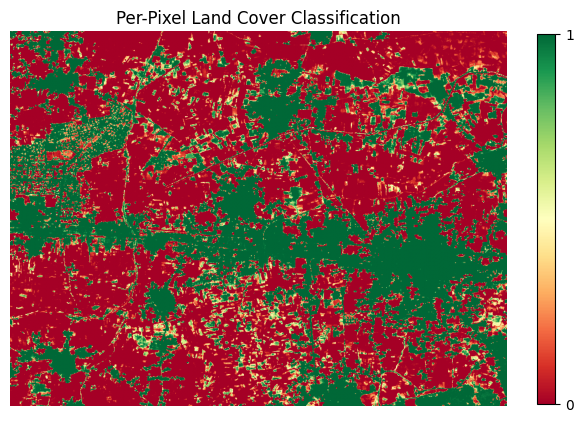

In [229]:
import matplotlib.pyplot as plt

vmin,vmax = 0,len(classes)-1

# Map class codes back to names, if you saved them
if classes is not None:
    cmap = plt.get_cmap('tab10', len(classes))
else:
    cmap = 'viridis'

with rasterio.open('lc_prob_and_pred.tif') as src:
    img = src.read(1)

plt.figure(figsize=(8,8))
im = plt.imshow(img, cmap='RdYlGn', vmin=vmin, vmax=vmax)
plt.axis('off')
cbar = plt.colorbar(im, ticks=np.arange(len(classes)),shrink=0.6)
cbar.ax.set_yticklabels(classes)
plt.title("Per-Pixel Land Cover Classification")
plt.show()


In [257]:
m = leafmap.Map(center=(37.5, 70), zoom=6)
m.add_basemap('Google Satellite')

# 1. Create a minimal GeoDataFrame with only geometry + Target
popup_gdf = stats_gdf[['geometry', 'target_label']].copy()

# 2. Add your styling layers *without* popups
layers_lsit = [ 
    (agriculture,    'Agriculture',             legend_dict['Agriculture']),
    (nonagriculture,   'NonAgricultrue',        legend_dict['Non-Agriculture']),
        ]

for gdf, name, color in layers_lsit:
    # 2.1 Add the layer to the map   
    m.add_gdf(
        gdf,
        layer_name=name,
        style={
            'color':    color,
            'fillColor':color,
            'fillOpacity':0.3,
            'weight':   1
        },
        zoom_to_layer=True,
        info_mode='off'   # make sure no popups for these layers
    )

# 3. Add your minimal layer *last*, with popups ON only for landuse_class
m.add_gdf(
    popup_gdf,
    layer_name='Landuse Class',
    style={
        'color':      'black',
        'fillColor': 'transparent',
        'fillOpacity':0.1,
        'weight':     1
    },
    info_mode='on_click'  # only this layer shows a popup
)

# Adding the predicted Agriculture and Non-Agriculture parcels
m.add_gdf(
    pred_agri,
    layer_name='Predicted Agri',
    style={
        'color': 'lightgreen',
        'fillColor': 'lightgreen',
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
)
m.add_gdf(
    pred_nonagri,
    layer_name='Predicted Non-Agri',
    style={
        'color': 'lightblue',
        'fillColor': 'lightblue',
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
)

# Adding the land classification raster
colorlist = ['darkgreen','darkblue']
classified_img = 'D:\Trainings\gee\Agri_NonAgri-clipped.tif'

#clippedimage = imagepath.clip(boundary.geometry())


m.add_raster(
    classified_img,
    layer_name='Landuse(Agri-NonAgri)',
    colormap= colorlist,
    opacity=0.5,
    nodata=None,
    legend=True,
    layer_opacity=0.3
)



# 4. Legend & Layer Manager
m.add_legend(
    legend_title='Agri vs Non-Agri',
    legend_dict=legend_dict,
    position='bottomleft'
)

m.add_layer_manager()

m


Map(center=[34.016954, 71.7731905], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping

# 1) Load boundary
cropfile    = r'D:\Trainings\gee\pabb_crop_V3.geojson'
imgboundary = gpd.read_file(cropfile).to_crs(epsg=4326)
shapes      = [mapping(imgboundary.geometry.unary_union)]

# 2) Open source
src_path = r'D:\Trainings\gee\lc_prob_and_pred.tif'
with rasterio.open(src_path) as src:
    # 3) Mask *without* filling with 0
    clipped_data, clipped_transform = mask(
        src,
        shapes,
        crop=True,        # trim the bounds
        nodata=None,      # leave outside as masked
        filled=False      # return a numpy MaskedArray
    )
    # clipped_data is a MaskedArray of shape (bands, H, W)
    clipped_mask = clipped_data.mask[0]  # True where mask, same shape H×W

    # 4) Update metadata, flag 0 as nodata
    out_meta = src.meta.copy()
    out_meta.update({
        "driver":    "GTiff",
        "height":    clipped_data.shape[1],
        "width":     clipped_data.shape[2],
        "transform": clipped_transform,
        "nodata":    0,         # Data value 0 = nodata
        "compress":  "lzw"
    })

# 5) Write out with a real nodata tag
out_path = r'D:\Trainings\gee\Agri_NonAgri-clipped.tif'
with rasterio.open(out_path, 'w', **out_meta) as dst:
    # fill masked data with 0 (nodata)
    dst.write(clipped_data.filled(0))
    # write the mask as the file’s mask
    dst.write_mask(~clipped_mask)  # invert: True=valid, False=nodata

print("Exported clipped, nodata‐aware raster:", out_path)
